In [1]:
!pip install -q nibabel imageio scikit-image tensorflow kagglehub

import os
import re
import shutil
import numpy as np
import nibabel as nib
import imageio
from skimage.transform import resize
from skimage.measure import label
from scipy.ndimage import binary_fill_holes
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import kagglehub
from google.colab import files
from random import randint
import pandas as pd


In [2]:
n_patients = 60
modalities = ["Flair", "T1", "T2"]

# Dataset da Kaggle
path = kagglehub.dataset_download("orvile/multiple-sclerosis-brain-mri-lesion-segmentation")

base_path = path  # Path .nii
output_path = '/content/slices'  # Path slice 2D in png
os.makedirs(output_path, exist_ok=True)

100%|██████████| 761M/761M [00:08<00:00, 98.8MB/s]

Extracting files...


In [3]:
modality = "Flair"
total_slices = 0

# Preprocessing e salvataggio PNG
for i in range(1, n_patients+1):
  try:
    img_path  = os.path.join(base_path, f'Patient-{i}', f'{i}-{modality}.nii')
    mask_path = os.path.join(base_path, f'Patient-{i}', f'{i}-LesionSeg-{modality}.nii')

    img_data = nib.load(img_path).get_fdata()
    mask_data = nib.load(mask_path).get_fdata()

    # Normalizzazione e binarizzazione
    img_data  = ((img_data - np.min(img_data)) * 255 / (np.max(img_data) - np.min(img_data))).astype(np.uint8)
    mask_data = ((mask_data > 0) * 255).astype(np.uint8)

    patient_folder = os.path.join(output_path, modality, f'Patient-{i}')
    os.makedirs(os.path.join(patient_folder, modality), exist_ok=True)
    os.makedirs(os.path.join(patient_folder, f'mask_{modality}'), exist_ok=True)

    for z in range(img_data.shape[2]):
      slice_img = img_data[:, :, z]
      slice_mask = mask_data[:, :, z]

      slice_img_resized = resize(slice_img, (256, 256), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
      slice_mask_resized = resize(slice_mask, (256, 256), order=0, preserve_range=True, anti_aliasing=False).astype(np.uint8)

      imageio.imwrite(os.path.join(patient_folder, modality, f'slice_{z:03d}.png'), slice_img_resized)
      imageio.imwrite(os.path.join(patient_folder, f'mask_{modality}', f'slice_{z:03d}.png'), slice_mask_resized)
      total_slices += 1

  except Exception as e:
    print(f"Patient-{i}: Error - {e}")
    continue
print(f"Completed {modality}: slice totali {total_slices}")


Completed Flair: slice totali 1451


In [18]:
# Utility per dataset
def sort_slices(files):
    return sorted(files, key=lambda f: int(re.search(r'\d+', os.path.basename(f)).group()))

def get_patient_paths_multimodal(base_path, modalities=['Flair', 'T1', 'T2']):
    patients = {}
    for i in range(1, n_patients+1):
        patient_folder = f"Patient-{i}"
        patient_data = {}

        for modality in modalities:
            img_folder = os.path.join(base_path, modality, patient_folder, modality)
            mask_folder = os.path.join(base_path, modality, patient_folder, f'mask_{modality}')

            if os.path.exists(img_folder) and os.path.exists(mask_folder):
                img_files = sort_slices([os.path.join(img_folder, f) for f in os.listdir(img_folder) if f.lower().endswith('.png')])
                mask_files = sort_slices([os.path.join(mask_folder, f) for f in os.listdir(mask_folder) if f.lower().endswith('.png')])

                if len(img_files) == len(mask_files) and len(img_files) > 2:  # Almeno 3 slice
                  patients[i] = {"images": img_files, "masks": mask_files}

    return patients

def get_train_val_test_data_multimodal(patients, modalities=['Flair', 'T1', 'T2'], test_size=0.2, val_size=0.2, random_state=42):
    patient_ids = list(patients.keys())

    train_patients, test_patients = train_test_split(patient_ids, test_size=test_size, random_state=random_state)
    train_patients, val_patients = train_test_split(train_patients, test_size=val_size/(1-test_size), random_state=random_state)

    def get_data(patient_list):
        data = {"images": [], "masks": []}
        for p_id in patient_list:
            data["images"].extend(patients[p_id]["images"])
            data["masks"].extend(patients[p_id]["masks"])

        return data

    return get_data(train_patients), get_data(val_patients), get_data(test_patients)


def augment_multimodal(imgs, mask):
    # Variazioni di intensità (per ogni canale)
    if tf.random.uniform([]) > 0.5:
        brightness_factor = tf.random.uniform([], 0.9, 1.1)
        imgs = imgs * brightness_factor
        imgs = tf.clip_by_value(imgs, 0.0, 1.0)

    # Gaussian noise (per ogni canale)
    if tf.random.uniform([]) > 0.5:
        noise = tf.random.normal(tf.shape(imgs), stddev=0.01)
        imgs = imgs + noise
        imgs = tf.clip_by_value(imgs, 0.0, 1.0)

    return imgs, mask


def create_dataset_multimodal(data_dict, modalities=['Flair', 'T1', 'T2'], batch_size=16, is_training=False):
    img_paths = data_dict['images']
    mask_paths = data_dict['masks']

    prev_paths = img_paths[:-2]
    curr_paths = img_paths[1:-1]
    next_paths = img_paths[2:]
    mask_paths_valid = mask_paths[1:-1]

    dataset = tf.data.Dataset.from_tensor_slices((prev_paths, curr_paths, next_paths, mask_paths_valid))

    def load_multimodal(prev_path, curr_path, next_path, mask_path):
        # Slice precedente
        img_prev = tf.io.read_file(prev_path)
        img_prev = tf.image.decode_png(img_prev, channels=1)
        img_prev = tf.cast(img_prev, tf.float32) / 255.0

        # Slice corrente
        img_curr = tf.io.read_file(curr_path)
        img_curr = tf.image.decode_png(img_curr, channels=1)
        img_curr = tf.cast(img_curr, tf.float32) / 255.0

        # Slice successiva
        img_next = tf.io.read_file(next_path)
        img_next = tf.image.decode_png(img_next, channels=1)
        img_next = tf.cast(img_next, tf.float32) / 255.0

        # Concatena i 3 canali
        img_3ch = tf.concat([img_prev, img_curr, img_next], axis=-1)

        # Maschera
        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels=1)
        mask = tf.cast(mask, tf.float32) / 255.0

        return img_3ch, mask

    dataset = dataset.map(load_multimodal, num_parallel_calls=tf.data.AUTOTUNE)
    num_samples = len(prev_paths)
    # Shuffle solo per training
    if is_training == True:
        dataset = dataset.shuffle(buffer_size=num_samples)
        dataset = dataset.map(augment_multimodal, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    if is_training == True:
        dataset = dataset.repeat()

    return dataset

# U-Net
def unet_model_multimodal(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Dropout(0.5)(c5)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Dropout(0.3)(c6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [5]:
def dice_loss(y_true, y_pred, smooth=1e-6):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  # Shape
  if len(y_true.shape) == 3:
      y_true = tf.expand_dims(y_true, axis=-1)
  if len(y_pred.shape) == 3:
      y_pred = tf.expand_dims(y_pred, axis=-1)

  y_true_f = tf.reshape(y_true, [tf.shape(y_true)[0], -1])
  y_pred_f = tf.reshape(y_pred, [tf.shape(y_pred)[0], -1])

  intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=1)

  return 1 - tf.reduce_mean((2. * intersection + smooth) /
                            (tf.reduce_sum(y_true_f, axis=1) + tf.reduce_sum(y_pred_f, axis=1) + smooth))

def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0, smooth=1e-7):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  # Shape
  if len(y_true.shape) == 3:
      y_true = tf.expand_dims(y_true, axis=-1)
  if len(y_pred.shape) == 3:
      y_pred = tf.expand_dims(y_pred, axis=-1)

  # Clip per stabilità numerica
  y_pred = tf.clip_by_value(y_pred, smooth, 1 - smooth)

  # Binary cross entropy
  bce = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)

  # Focal term: riduce il peso degli esempi facili
  p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
  focal_term = tf.pow(1 - p_t, gamma)

  # Alpha balancing
  alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)

  focal = alpha_t * focal_term * bce

  return tf.reduce_mean(focal)

def combined_focal_dice_loss(y_true, y_pred, alpha=0.75, gamma=2.0, dice_weight=0.35, focal_weight=0.65):
  dl = dice_loss(y_true, y_pred)
  fl = focal_loss(y_true, y_pred, alpha=alpha, gamma=gamma)

  return dice_weight * dl + focal_weight * fl


In [6]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


In [19]:
### Modalità loss statica ###

slice_path = f'/content/slices'

# Preparazione dataset
patients_dict = get_patient_paths_multimodal(slice_path)
train_data, val_data, test_data = get_train_val_test_data_multimodal(patients_dict)

num_train_images = len(train_data['images'])
num_val_images = len(val_data['images'])

batch_size = 16
oversample_factor = 3

steps_per_epoch = num_train_images * oversample_factor // batch_size
validation_steps = num_val_images // batch_size

train_dataset = create_dataset_multimodal(train_data, modalities=modalities, batch_size=batch_size, is_training=True)
val_dataset = create_dataset_multimodal(val_data)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-5,
    clipnorm=1.0
)

model_multimodal = unet_model_multimodal(input_size=(256, 256, 3))
model_multimodal.compile(
    optimizer=optimizer,
    loss=combined_focal_dice_loss,
    metrics=[dice_coef, iou_coef, tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

early_stop = EarlyStopping(monitor='val_dice_coef', patience=10, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_dice_coef',
    factor=0.5,
    patience=6,
    min_lr=1e-7,
    mode='max',
    verbose=1
)
history = model_multimodal.fit(train_dataset, validation_data=val_dataset, epochs=50, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, callbacks=[early_stop, reduce_lr])

# Test
test_dataset = create_dataset_multimodal(test_data)
results = model_multimodal.evaluate(test_dataset)

# Recupero variabili di test
test_loss = results[0]
test_dice = results[1]
test_iou = results[2]
test_precision = results[3]
test_recall = results[4]
test_acc = results[5]

print(f"Modality: Multimodal (Flair + T1 + T2)")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Dice: {test_dice:.4f}")
print(f"Test IoU: {test_iou:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

model_multimodal.save('/content/model.h5')



Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.9972 - dice_coef: 0.0041 - iou_coef: 0.0020 - loss: 0.3741 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9961 - val_dice_coef: 0.0017 - val_iou_coef: 8.7152e-04 - val_loss: 0.3587 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 137s 843ms/step - accuracy: 0.9977 - dice_coef: 0.0099 - iou_coef: 0.0050 - loss: 0.3513 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9961 - val_dice_coef: 0.0467 - val_iou_coef: 0.0243 - val_loss: 0.3399 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 137s 841ms/step - accuracy: 0.9977 - dice_coef: 0.0446 - iou_coef: 0.0229 - loss: 0.3429 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9961 - val_dice_coef: 0.0736 - val_iou_coef: 0.0394 - val_loss: 0.3354 - val_precision: 0.0000e+00 - val_recall: 0.0000

Modality: Multimodal (Flair + T1 + T2)
Test Loss: 0.1453
Test Dice: 0.5149
Test IoU: 0.3719
Test Precision: 0.6412
Test Recall: 0.5572
Test Accuracy: 0.9977


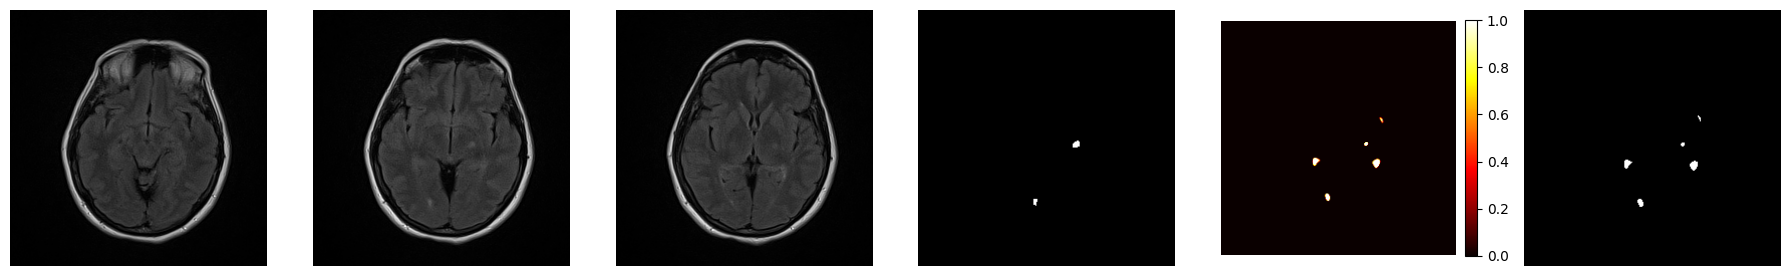

Sample 10: Dice Score = 3.1041


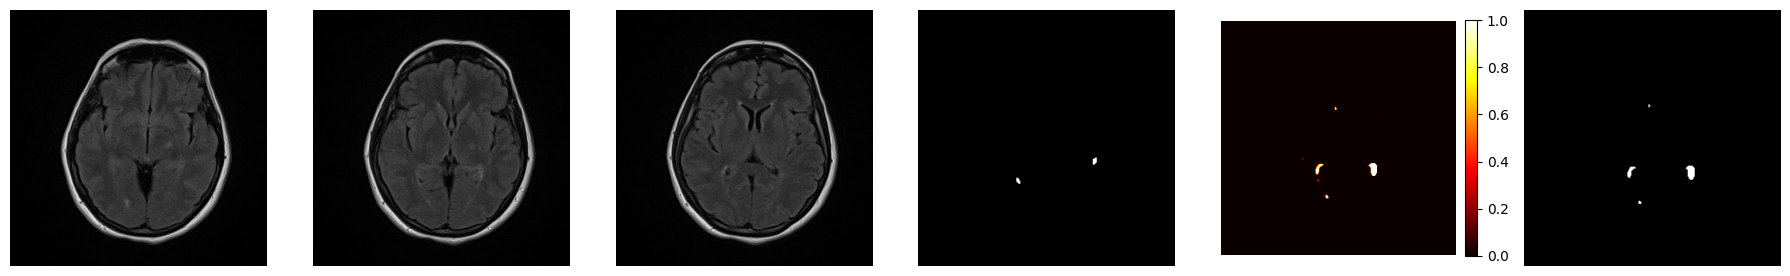

Sample 11: Dice Score = 0.0000


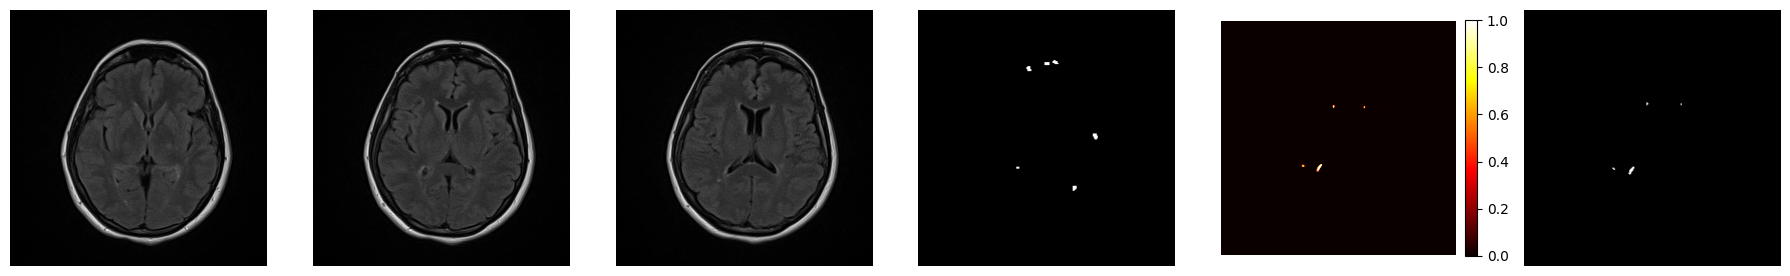

Sample 12: Dice Score = 0.0945


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
from tensorflow.keras.models import load_model
from google.colab import files
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Carica modello
model_multimodal = load_model('/content/model.h5', compile=False)

# Parametri
num_samples = 3
base_path = '/content/slices'
modalities = ['Flair']  # Usa solo Flair con 3 slice consecutive

# Prepara dataset
patients_dict = get_patient_paths_multimodal(base_path, modalities)
_, _, test_data = get_train_val_test_data_multimodal(patients_dict, modalities)

img_paths = test_data['images']
mask_paths = test_data['masks']

# Skip iniziale per evitare bordi
skip = 10

for idx in range(skip, min(skip + num_samples, len(img_paths) - 2)):
    # Carica 3 slice consecutive (prev, curr, next)
    prev_img = tf.io.read_file(img_paths[idx - 1])
    prev_img = tf.image.decode_png(prev_img, channels=1)
    prev_img = tf.cast(prev_img, tf.float32) / 255.0

    curr_img = tf.io.read_file(img_paths[idx])
    curr_img = tf.image.decode_png(curr_img, channels=1)
    curr_img = tf.cast(curr_img, tf.float32) / 255.0

    next_img = tf.io.read_file(img_paths[idx + 1])
    next_img = tf.image.decode_png(next_img, channels=1)
    next_img = tf.cast(next_img, tf.float32) / 255.0

    # Concatena i 3 canali (come nel training)
    multimodal_img = tf.concat([prev_img, curr_img, next_img], axis=-1)

    # Carica maschera ground truth (della slice corrente)
    mask_img = tf.io.read_file(mask_paths[idx])
    mask_img = tf.image.decode_png(mask_img, channels=1)
    mask_img = tf.cast(mask_img, tf.float32) / 255.0

    # Predizione
    pred_mask = model_multimodal.predict(tf.expand_dims(multimodal_img, axis=0), verbose=0)[0,:,:,0]

    # Binarizzazione
    pred_mask_binary = (pred_mask > 0.5).astype(float)

    # Calcola Dice
    dice_score = 2 * np.sum(mask_img.numpy() * pred_mask_binary) / (np.sum(mask_img.numpy()) + np.sum(pred_mask_binary) + 1e-7)

    # Visualizzazione
    plt.figure(figsize=(18, 4))

    plt.subplot(1, 6, 1)
    plt.imshow(prev_img[:,:,0], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 6, 2)
    plt.imshow(curr_img[:,:,0], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 6, 3)
    plt.imshow(next_img[:,:,0], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 6, 4)
    plt.imshow(mask_img[:,:,0], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 6, 5)
    plt.imshow(pred_mask, cmap='hot', vmin=0, vmax=1)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis('off')

    plt.subplot(1, 6, 6)
    plt.imshow(pred_mask_binary, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig(f'/content/predict_multimodal_{idx}.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Sample {idx}: Dice Score = {dice_score:.4f}")

# Scarica tutti
import glob
png_files = glob.glob('/content/predict_multimodal_*.png')
for png in png_files:
    files.download(png)


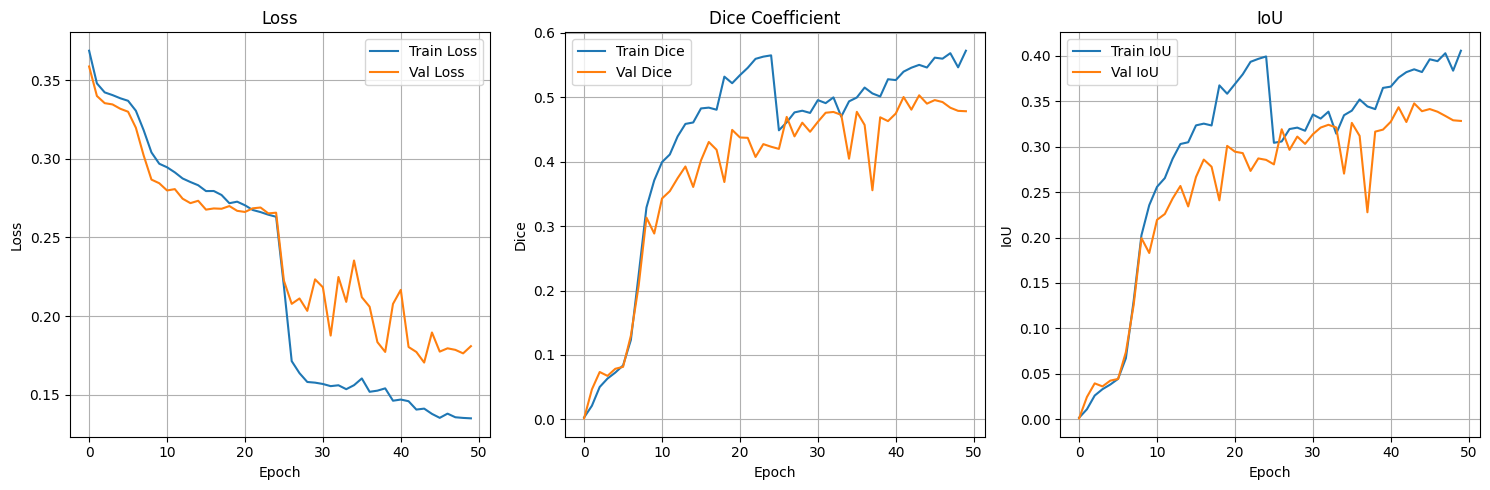

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
## Grafico di apprendimento statico
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history.history['dice_coef'], label='Train Dice')
plt.plot(history.history['val_dice_coef'], label='Val Dice')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history.history['iou_coef'], label='Train IoU')
plt.plot(history.history['val_iou_coef'], label='Val IoU')
plt.title('IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('/content/multimodal_static_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

files.download('/content/multimodal_static_training_history.png')
